# Treinamento CIS - 4º Período (Redes Neurais Convolucionais)

## Importação das bibliotecas e demais ferramentas usadas

Para este projeto, configurei a API do Kaggle para acessar o dataset "Classificação de Nuvens" diretamente, eliminando a necessidade de fazer o upload para o meu Google Drive, como fiz até então. Em seguida, importei as bibliotecas necessárias para a atividade.

In [12]:
from google.colab import files
files.upload() #importando credenciais do Kaggle para encontrar o dataset

{}

In [ ]:
# colocando o arquivo de credencial no local apropriado
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# importando o dataset
!kaggle competitions download -c classificandos-nuvens-usando-cnn

# descompactando o arquivo
!unzip -q classificandos-nuvens-usando-cnn.zip

  0% 0.00/5.11M [00:00<?, ?B/s]
100% 5.11M/5.11M [00:00<00:00, 349MB/s]


In [84]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.image as mpimg

## Separação dos dados para treino e teste

Separação entre dados para treino e teste e obtenção das classes de nuvens.


Um detalhe: observando o dataset, há a seguinte quantidade de imagens em cada classe:
* cirriform clouds: 66
* clear sky: 60
* cumulonimbus clouds: 14
* cumulus clouds: 91
* high cumuliform clouds: 133
* stratiform clouds: 49
* stratocumulus clouds: 61

Sendo assim, para diminuir o desbalanceamento da quantidade de imagens em cada classe, utilizarei data augmentation nas classes cumulonimbus clouds e stratiform clouds.

In [89]:
# definindo as transformações
transform_normal = transforms.Compose([
    transforms.ToTensor(), # transforma em tensor porque vem como imagem PIL ou numpyArray e altera de (altura, largura, canais) para (canais, altura, largura)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalizando para a faixa -1-1 com média e desvio-padrão de 0.5 (centralização dos dados ao redor de zero) os valores dos pixels (originalmente na faixa 0-255)
])

# transformacoes para augmentacao
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    #transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # redimensionando recorte da imagem para 32px, sendo de 80 a 100 por cento da area da imagem original (mudancas de perspectiva e composicao)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def carregar_com_augmentacao(dataset, transform_normal, transform_aug, classes_minoritarias):
  ''' funcao que carrega augmentaçao em classes especificas '''
  augmented_images = []

  for caminho, classe in dataset.imgs:
      imagem = Image.open(caminho)
      classe_nome = dataset.classes[classe]

      if classe_nome == 'cumulonimbus clouds':
          augmented = [transform_aug(imagem) for _ in range(3)]
      elif classe_nome == 'stratiform clouds':
          augmented = [transform_aug(imagem) for _ in range(1)]
      else:
          augmented = []

      augmented_images.extend((img, classe) for img in augmented)

      # sempre adiciona as imagens originais
      original_img = transform_normal(imagem)
      augmented_images.append((original_img, classe))

  return augmented_images


# diretorios dos dados
train_dir = './clouds/clouds_train'
test_dir = './clouds/clouds_test'

# carregando os dados de treinamento com seleção de augmentação
trainset_original = ImageFolder(root=train_dir, transform=None)
classes_minoritarias = ['cumulonimbus clouds', 'stratiform clouds']
train_data = carregar_com_augmentacao(trainset_original, transform_normal, transform_aug, classes_minoritarias)

batch_size = 4 # tamanho do batch

# criando DataLoader
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, # embaralhamento para evitar viés no modelo
                         num_workers=2)

# carregando os dados de teste sem augmentação
testset = ImageFolder(root=test_dir, transform=transform_normal)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


# obtendo as classes
classes = trainset_original.classes
print("Classes:", classes)

Classes: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


Plotando as imagens para verificar se as imagens foram carregadas e transformadas e se as etiquetas dos dados estão sendo lidas corretamente.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = (img * 0.5) + 0.5  # desnormalizar imagens
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


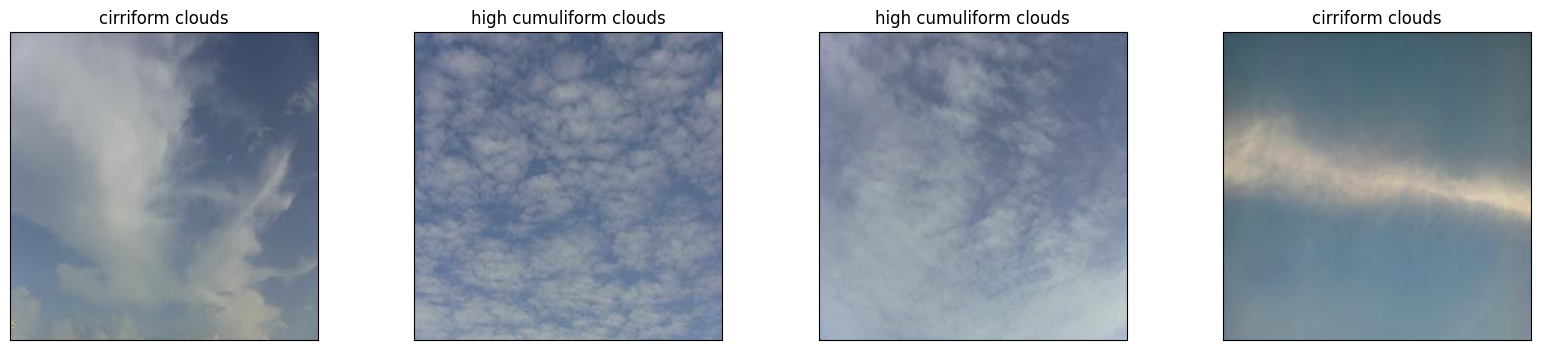

In [38]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

Amostra ok.

## Definindo a rede convolucional

Para calcular o tamanho espacial da saida podemos usar a fórmula `((N − F + 2P) / S) + 1.` (dimensão da imagem resultante depois de passar por convucional layer).

onde:

N : Dimensão da imagem de entrada

F : Dimensão do Filtro

P : O padding

S : O stride

Lembrando que um maxpooling de (kernel_size = 2,stride = 2) diminui pela metade a dimensão da imagem nos eixos x e y

do segundo pooling faço um flatten da matriz e faço três fully connected layers

saber como que isso funciona é importante porque lá no final vou fazer uma funçao de probabilidade e gerar uma classe.

In [90]:
class CNN(nn.Module):
    '''arquitetura da rede neural convolucional'''
    def __init__(self):
        super().__init__()  # inicializa a superclasse nn.Module
        self.conv1 = nn.Conv2d(3, 6, 5)  # primeira camada convolucional: 3 canais de entrada (RGB), 6 filtros 5x5 de saída
        self.pool = nn.MaxPool2d(2, 2)  # camada de pooling: reduz dimensões pela metade com kernel 2x2
        self.conv2 = nn.Conv2d(6, 16, 5)  # segunda camada convolucional: 6 canais de entrada, 16 filtros 5x5 de saída
        self.fc1 = nn.Linear(61 * 61 * 16, 120)  # primeira camada totalmente conectada: entrada calculada a partir da saída da convolução, 120 unidades de saída
        self.fc2 = nn.Linear(120, 84)  # segunda camada totalmente conectada: 120 unidades de entrada, 84 de saída
        self.fc3 = nn.Linear(84, 7)  # última camada totalmente conectada: 84 unidades de entrada, 7 classes de saída

    def forward(self, x):
        '''definindo comportamento da rede neural convolucional'''
        x = self.pool(F.relu(self.conv1(x)))  # aplica convolução, função de ativação ReLU e pooling
        x = self.pool(F.relu(self.conv2(x)))  # aplica segunda convolução, ReLU e pooling
        x = torch.flatten(x, 1)  # achata todas as dimensões exceto a do batch
        x = F.relu(self.fc1(x))  # aplica primeira camada totalmente conectada e ReLU
        x = F.relu(self.fc2(x))  # aplica segunda camada totalmente conectada e ReLU
        x = self.fc3(x)  # aplica última camada totalmente conectada para obter a saída final
        return x

cnn = CNN()  # instancia a rede neural convolucional

Utilizarei o o otimizador Adam (Adaptive Moment Estimation), por causa da robustez e eficiência em ajustes de parâmetros de redes neurais, e a função de perda categorical_crossentropy, que é apropriada para problemas de classificação multiclasse.

In [91]:
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

## Treinando o modelo

Diferentemente da última atividade, as fases de treinamento e teste do modelo serão separadas. Por isso, a saída desse código será somente `[epoch, mini-batch] loss: valor`.

In [92]:
epochs = 4 # ao definir isso, tomar cuidado com overfitting
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # pega os inputs; dados sao uma lista de [inputs, labels]
        inputs, labels = data

        # zera os gradientes de todas as variaveis para cada batch para não acumular
        optimizer.zero_grad()

        # forward + backward + otimizador
        outputs = cnn(inputs)
        loss = criterion(outputs, labels) # calcula loss da batch
        loss.backward() # Computa o gradiente da loss com relação aos parametros do modelo
        optimizer.step() # Update dos parametros

        running_loss += loss.item()
        if i % 10 == 9:    # Imprimir a cada 10 mini-batches
          avg_loss = running_loss / 10
          print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, avg_loss))
          train_losses.append(avg_loss)
          running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.986
[1,    20] loss: 1.772
[1,    30] loss: 1.559
[1,    40] loss: 1.456
[1,    50] loss: 1.574
[1,    60] loss: 1.504
[1,    70] loss: 1.380
[1,    80] loss: 1.379
[1,    90] loss: 1.365
[1,   100] loss: 1.346
[1,   110] loss: 1.367
[1,   120] loss: 1.207
[1,   130] loss: 1.132
[1,   140] loss: 1.133
[2,    10] loss: 1.488
[2,    20] loss: 1.203
[2,    30] loss: 1.165
[2,    40] loss: 1.220
[2,    50] loss: 1.449
[2,    60] loss: 1.133
[2,    70] loss: 1.140
[2,    80] loss: 0.881
[2,    90] loss: 0.759
[2,   100] loss: 1.072
[2,   110] loss: 1.254
[2,   120] loss: 1.012
[2,   130] loss: 1.480
[2,   140] loss: 1.423
[3,    10] loss: 1.166
[3,    20] loss: 1.111
[3,    30] loss: 1.017
[3,    40] loss: 1.382
[3,    50] loss: 1.117
[3,    60] loss: 1.141
[3,    70] loss: 0.826
[3,    80] loss: 0.669
[3,    90] loss: 0.582
[3,   100] loss: 0.901
[3,   110] loss: 0.883
[3,   120] loss: 1.520
[3,   130] loss: 1.215
[3,   140] loss: 1.232
[4,    10] loss: 0.936
[4,    20] 

Plotando o gráfico com os outputs, temos que:

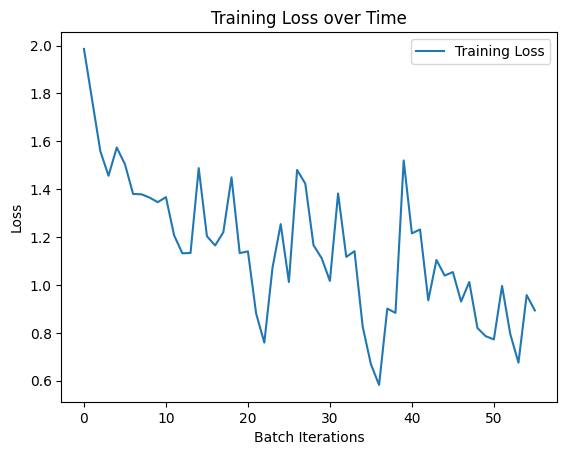

In [93]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.show()

O gráfico mostra flutuações na perda que podem indicar ruído ou necessidade de tuning nos hiperparâmetros.

Mesmo que a tendência geral sugira que ele está aprendendo, as oscilações poderiam ser suavizadas mediante ajustes na taxa de aprendizado ou no tamanho dos batches, porque uma taxa de aprendizado muito alta pode estar causando saltos excessivos ou batches pequenos podem estar aumentando a variabilidade entre as iterações.

Algumas ideias de melhora de desempenho são: testar redução na taxa de aprendizado, aumentar o tamanho dos batches e/ou introduzir técnicas de regularização --- como dropout.

Isso é uma ideia de melhora posterior. Por ora, seguirei com o modelo que tenho, já sabendo que ele provavelmente não terá uma acurácia geral excelente.

Para testar o modelo posteriormente, irei salvá-lo.

In [67]:
torch.save(cnn.state_dict(), # obtém o dicionário de estado do modelo cnn, que contém os parâmetros do modelo
           'modelo.pth')

## Testando o modelo


Importando o modelo treinado

In [69]:
cnn = CNN() # carregar os parâmtros do modelo
cnn.load_state_dict(torch.load('modelo.pth'))
cnn.eval()  # define para modo de avaliação, se necessário

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)

Testando o modelo

In [74]:
correct = 0
total = 0
# nao precisamos calcular os valores de gradiente pq não estamos treinando
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        # a classe com a maior pontuação é a que escolhemos como predição
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Acurácia do modelo: %d %%' % (100 * correct / total)) # (número de acertos) / (número total de amostras) × 100%

Acurácia do modelo: 55 %


Como esperado, a acurácia geral foi baixa. Para uma análise mais profunda, examinarei o desempenho por classe.

In [75]:
# prepara para contar as previsões para cada classe
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# novamente, sem necessidade de calcular gradientes
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # calcula predições corretas para cada classe
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# imprime a acurácia para cada classe
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class cirriform clouds is: 57.1 %
Accuracy for class clear sky is: 89.1 %
Accuracy for class cumulonimbus clouds is: 36.4 %
Accuracy for class cumulus clouds is: 43.3 %
Accuracy for class high cumuliform clouds is: 17.5 %
Accuracy for class stratiform clouds is: 97.5 %
Accuracy for class stratocumulus clouds is: 80.3 %


As acurácias variam bastante entre as classes: de 17.5% a 97.5%.

Isso sugere um desbalanceamento ou dificuldades em particular para aprender certas classes. Em especial, Cumulonimbus e High Cumuliform Clouds, indicando que o modelo tem dificuldade em distinguir essas classes. Já para Stratiform Clouds há uma alta acurácia, sugerindo que o modelo tem boa precisão para esta classe.

Como já me utilizei da Data Augmentation para combater o desbalanceamento do dataset, ou seja, só o utilizei nas classes que haviam menos exemplos, imagino que fazer uma nova rodada de Data Augmentation não seria a  melhor alternativa, pois nesta caso, aumentar as imagens nas classes com acurácia mais baixa provavelmente não melhorará o aprendizado, já que a classe com mais exemplos também foi a classe com menor acurácia (High Cumuliform Clouds).

Da mesma forma, não acho que seja um caso de overfitting, já que a acurácia não é alta nas classes que o modelo vê com mais frequência. Pórem, como em muitas classes as acurácias são relativamente baixas, talvez seja um caso de underfitting. De qualquer forma, reservarei espaço para esta discussão após os próximos passos.

Como já sugerido em "Treinando o modelo", para buscar um melhor desempenho, eu faria um tuning de hiperparâmetros ou, como sugerido pela atividade, modificaria a arquitetura do modelo utilizando o transfer learning.

## Transfer Learning e avaliar no dataset

Utilizarei transfer learning com a arquitetura ResNet, modificando, primeiramente, o código originalmente apresentado na seção 'Separação dos dados para treino e teste':

In [94]:
# definindo as transformações
transform_aug1 = transforms.Compose([
    transforms.Resize((224, 224)),  # ajustar o tamanho para 224x224 pixels, como é comum para ResNet
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalização baseada em ImageNet, que foi utilizada para o treinamento do ResNet
])

transform_normal1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Função que carrega augmentação em classes específicas
def carregar_com_augmentacao(dataset, transform_normal, transform_aug, classes_minoritarias):
    augmented_images1 = []

    for caminho, classe in dataset.imgs:
        imagem = Image.open(caminho)
        classe_nome = dataset.classes[classe]

        if classe_nome == 'cumulonimbus clouds':
            augmented = [transform_aug(imagem) for _ in range(3)]
        elif classe_nome == 'stratiform clouds':
            augmented = [transform_aug(imagem) for _ in range(1)]
        else:
            augmented = []

        augmented_images1.extend((img, classe) for img in augmented)

        # sempre adiciona as imagens originais
        original_img = transform_normal(imagem)
        augmented_images1.append((original_img, classe))

    return augmented_images1

# diretórios dos dados
train_dir1 = './clouds/clouds_train'
test_dir1 = './clouds/clouds_test'

# carregando os dados de treinamento com seleção de augmentação
trainset_original1 = ImageFolder(root=train_dir1, transform=None)
classes_minoritarias1 = ['cumulonimbus clouds', 'stratiform clouds']
train_data1 = carregar_com_augmentacao(trainset_original1, transform_normal1, transform_aug1, classes_minoritarias1)

batch_size1 = 4

# criando DataLoader
trainloader1 = DataLoader(train_data1, batch_size=batch_size1, shuffle=True, num_workers=2)

# carregando os dados de teste sem augmentação
testset1 = ImageFolder(root=test_dir1, transform=transform_normal1)
testloader1 = DataLoader(testset1, batch_size=batch_size1, shuffle=False, num_workers=2)

# obtendo as classes
classes1 = trainset_original1.classes
print("Classes:", classes1)

# carregar a ResNet pré-treinada
model = models.resnet18(pretrained=True)

# mudar a última camada para o número de classes do dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 7 classes

# Preparar o criterion e otimizador
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model.fc.parameters(), lr=0.001)

Classes: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fazendo o treinamento do novo modelo:

In [95]:
# como o colab disponibiliza GPUs, vou tentar a sorte e ver se tem alguma disponivel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs1 = 4
train_losses1 = []

for epoch in range(epochs1):
    running_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        # pega os inputs; dados sao uma lista de [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # movendo os dados para o dispositivo correto

        # zera os gradientes de todas as variaveis para cada batch para não acumular
        optimizer1.zero_grad()

        # forward + backward + otimizador
        outputs = model(inputs)  # usando model em vez de cnn
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()

        running_loss += loss.item()
        if i % 10 == 9:  # Imprimir a cada 10 mini-batches
            avg_loss = running_loss / 10
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, avg_loss))
            train_losses1.append(avg_loss)
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 2.056
[1,    20] loss: 1.934
[1,    30] loss: 1.790
[1,    40] loss: 1.249
[1,    50] loss: 1.431
[1,    60] loss: 1.327
[1,    70] loss: 1.261
[1,    80] loss: 1.281
[1,    90] loss: 1.172
[1,   100] loss: 1.119
[1,   110] loss: 1.314
[1,   120] loss: 1.090
[1,   130] loss: 1.214
[1,   140] loss: 1.099
[2,    10] loss: 0.957
[2,    20] loss: 1.218
[2,    30] loss: 0.912
[2,    40] loss: 0.949
[2,    50] loss: 1.096
[2,    60] loss: 0.901
[2,    70] loss: 0.817
[2,    80] loss: 0.920
[2,    90] loss: 0.909
[2,   100] loss: 0.928
[2,   110] loss: 0.836
[2,   120] loss: 0.762
[2,   130] loss: 0.895
[2,   140] loss: 0.774
[3,    10] loss: 0.999
[3,    20] loss: 0.984
[3,    30] loss: 0.791
[3,    40] loss: 0.672
[3,    50] loss: 0.823
[3,    60] loss: 0.771
[3,    70] loss: 1.017
[3,    80] loss: 0.736
[3,    90] loss: 0.826
[3,   100] loss: 0.916
[3,   110] loss: 0.559
[3,   120] loss: 0.818
[3,   130] loss: 1.173
[3,   140] loss: 0.967
[4,    10] loss: 0.767
[4,    20] 

Plotando o gráfico para entender as diferenças de treinamento entre os dois modelos:

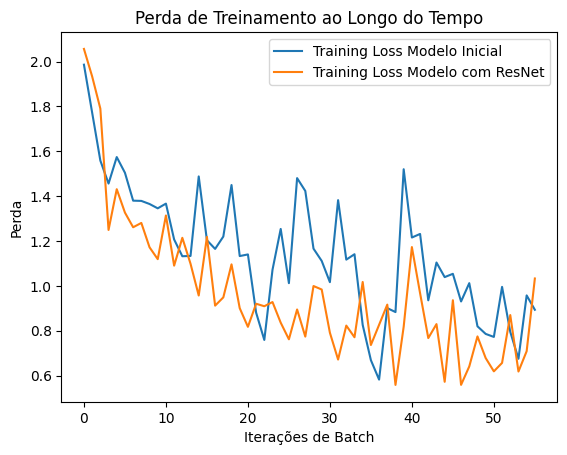

In [97]:
# Criar o gráfico
plt.plot(train_losses, label='Training Loss Modelo Inicial')
plt.plot(train_losses1, label='Training Loss Modelo com ResNet')

# Configurar o gráfico
plt.xlabel('Iterações de Batch')
plt.ylabel('Perda')
plt.title('Perda de Treinamento ao Longo do Tempo')
plt.legend()

# Exibir o gráfico
plt.show()

Analisando o gráfico, o modelo com ResNet (linha laranja) apresenta uma rápida queda na perda comparado ao modelo inicial (linha azul), o que indica que ele está aprendendo de forma mais eficiente.

A curva da ResNet tem relativamente menos oscilações e convergência mais rápida, sugerindo robustez e um ajuste mais estável aos dados de treino do que o modelo anterior. Em contraste, o modelo inicial exibe flutuações maiores e um padrão menos consistente.

Para testar a hipótese de que a ResNet é melhor para este problema abordado, validarei o modelo nos dados de teste.

Salvando o modelo com ResNet

In [98]:
torch.save(cnn.state_dict(), # obtém o dicionário de estado do modelo cnn, que contém os parâmetros do modelo
           'modelo.pth1')

Importando o modelo treinado

In [99]:
cnn = CNN() # carregar os parâmtros do modelo
cnn.load_state_dict(torch.load('modelo.pth1'))
cnn.eval()  # define para modo de avaliação, se necessário

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)

Testando o modelo

In [100]:
correct = 0
total = 0
# nao precisamos calcular os valores de gradiente pq não estamos treinando
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        # a classe com a maior pontuação é a que escolhemos como predição
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Acurácia do modelo: %d %%' % (100 * correct / total)) # (número de acertos) / (número total de amostras) × 100%

Acurácia do modelo: 55 %


A acurácia nos testes foi a mesma para ambos os modelos, o que reforça a hipóstese da necessidade um tuning mais aprofundado de hiperparâmetros, um caso de underfitting ou ainda uma possível reavaliação das estratégias de balanceamento e augmentação de dados para alcançar um desempenho melhor.

Observarei agora a acurácia de cada classe:

In [101]:
# prepara para contar as previsões para cada classe
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# novamente, sem necessidade de calcular gradientes
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # calcula predições corretas para cada classe
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# imprime a acurácia para cada classe
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class cirriform clouds is: 32.5 %
Accuracy for class clear sky is: 95.3 %
Accuracy for class cumulonimbus clouds is: 72.7 %
Accuracy for class cumulus clouds is: 21.7 %
Accuracy for class high cumuliform clouds is: 72.8 %
Accuracy for class stratiform clouds is: 57.5 %
Accuracy for class stratocumulus clouds is: 70.4 %


Analisando as acurácias por classe de ambos os modelos, há melhorias significativas em algumas classes com o novo modelo, como "Clear Sky", que subiu para 95.3%, e "Cumulonimbus Clouds" e "High Cumuliform Clouds", que mostraram aumentos expressivos.

No entanto, houve uma queda notável em "Cirriform Clouds", cuja acurácia caiu para 32.5%, e em "Cumulus Clouds".

Enquanto "Stratiform Clouds" e "Stratocumulus Clouds" mantêm um bom desempenho, a variação entre as classes sugere que o novo modelo está aprendendo bem algumas características específicas, mas ainda encontra dificuldades para generalizar em outras.

## Conclusão

Assim, concluo nesta atividade que o uso de ResNet foi benéfico para o problema abordado, pois houve uma aprendizagem mais rápida e eficiente. Porém, tendo em vista a baixa acurácia do modelo durante a etapa de testes, faria em ordem: avaliar um possível underfitting, um tuning de hiperparâmetros, uma reavaliação das estratégias de balanceamento e augmentação de dados, visando melhorar o desempenho global da classificação de nuvens.